# ClickHouse Query Trace Metrics Analysis

This notebook reads query trace CSV files and computes:
1. **CPU Usage Over Time**: (OSCPUVirtualTimeMicroseconds diff) / (timestamp diff)
2. **CPU Time Provisioned**: (ConcurrencyControlUpscales - ConcurrencyControlDownscales - ConcurrencyControlPreemptions + ConcurrencyControlPreemptionResumes) * timestamp_diff - ConcurrencyControlPreemptedMicroseconds_diff

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [129]:
# Configuration - modify this path to your CSV file
csv_path_2 = r"H:\ClickHouse\tpch\output\open\20260127_041936\001_default_rate0.27_len120_s123_query_traces\np_default_58_199_89cd939b.csv"
csv_path = r"H:\ClickHouse\tpch\output\open\20260127_045534\001_tpch_test_all_rate1.2_len120_s123_query_traces\021_tpch_all_90981_86432fc6.csv"

In [130]:
def load_trace_data(file_path: str) -> pd.DataFrame:
    """Load CSV trace data and return a DataFrame."""
    df = pd.read_csv(file_path)
    # Remove any empty rows
    df = df.dropna(subset=['timestamp_ms'])
    # Sort by timestamp
    df = df.sort_values('timestamp_ms').reset_index(drop=True)
    return df

df = load_trace_data(csv_path)
df = df[:-1]
print(f"Loaded {len(df)} rows")
df.head()

Loaded 24 rows


,timestamp_ms,AggregationHashTablesInitializedAsTwoLevel,AggregationPreallocatedElementsInHashTables,ArenaAllocBytes,ArenaAllocChunks,CompressedReadBufferBlocks,CompressedReadBufferBytes,ConcurrencyControlDownscales,ConcurrencyControlPreemptedMicroseconds,ConcurrencyControlPreemptionResumes,...,SharedPartsLockHoldMicroseconds,SharedPartsLocks,SoftPageFaults,SynchronousReadWaitMicroseconds,SystemTimeMicroseconds,ThreadPoolReaderPageCacheHit,ThreadPoolReaderPageCacheHitBytes,ThreadPoolReaderPageCacheHitElapsedMicroseconds,UserTimeMicroseconds,WaitMarksLoadMicroseconds
0,90997.46,0,0,0,0,0,0,0,0,0,...,2,10,0,0,0,0,0,0,0,0
1,91267.49,0,0,61440,4,2987,282950259,0,293354,17,...,6,14,81263,123420,159195,1272,161841014,116530,398811,550
2,91559.41,0,0,1065091072,767,8306,631536243,0,293354,17,...,6,14,661330,219376,1343811,2872,371556214,211251,3867548,948
3,91841.82,0,0,1073479680,768,11250,824474227,0,570376,25,...,6,14,775320,250027,1579489,3721,482836342,241189,5841755,948
4,92105.48,0,0,2147221504,832,13684,983988851,0,3080247,49,...,6,14,877053,281486,1758555,4417,574020586,272004,7382074,948


In [131]:
df_2 = load_trace_data(csv_path_2)
df_2 = df_2[:-1]
print(f"Loaded {len(df)} rows")
df_2

Loaded 24 rows


,timestamp_ms,ArenaAllocBytes,ArenaAllocChunks,CompressedReadBufferBlocks,CompressedReadBufferBytes,ContextLock,CreatedReadBufferOrdinary,DiskReadElapsedMicroseconds,FileOpen,FilteringMarksWithPrimaryKeyMicroseconds,...,SharedPartsLockHoldMicroseconds,SharedPartsLocks,SoftPageFaults,SynchronousReadWaitMicroseconds,SystemTimeMicroseconds,ThreadPoolReaderPageCacheHit,ThreadPoolReaderPageCacheHitBytes,ThreadPoolReaderPageCacheHitElapsedMicroseconds,UserTimeMicroseconds,WaitMarksLoadMicroseconds
0,1206.18,253952,62,31496,2074019162,112,621,316066,72,9,...,4,3,397315,319856,2070749,5032,658102638,316066,3004056,2350
1,2208.37,253952,62,43237,2847724570,114,621,350942,72,9,...,4,3,397563,355490,2111652,6752,883546478,350942,4913453,2350
2,3218.00,253952,62,55059,3627003846,116,621,384838,72,9,...,4,3,397654,390226,2159985,8491,1111480686,384838,6827709,2350
3,4220.14,253952,62,66792,4399907448,118,621,417958,72,9,...,4,3,399377,424102,2193764,10212,1337055598,417958,8775299,2350
4,5222.86,253952,62,78588,5177229402,120,621,450055,72,9,...,4,3,399442,457014,2239236,11947,1564465518,450055,10688489,2350
5,6225.56,253952,62,90669,5973217050,121,621,482166,72,9,...,4,3,399761,489915,2272020,13722,1797118318,482166,12555332,2350
6,7228.30,253952,62,100984,6652937218,123,621,516571,72,9,...,4,3,409155,525192,2338761,15236,1995561326,516571,14734019,2350
7,8231.41,253952,62,111821,7367132630,125,621,550339,72,9,...,4,3,414517,559775,2404730,16829,2204359022,550339,16727954,2350
8,9234.65,253952,62,123610,8143718314,127,621,583647,72,9,...,4,3,414891,593876,2438798,18557,2430851438,583647,18649615,2350
9,10237.18,253952,62,135368,8918537834,129,621,616731,72,9,...,4,3,416231,627759,2486836,20283,2657081710,616731,20538883,2350


In [132]:
def compute_cpu_usage(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute CPU usage over time.
    CPU Usage = (OSCPUVirtualTimeMicroseconds diff) / (timestamp diff in microseconds)
    
    Returns a DataFrame with timestamp and cpu_usage columns.
    """
    result = df[['timestamp_ms']].copy()
    
    # Calculate diffs
    cpu_time_diff = df['OSCPUVirtualTimeMicroseconds'].diff()
    timestamp_diff_us = df['timestamp_ms'].diff() * 1000  # Convert ms to microseconds
    
    # CPU usage ratio (can be > 1 if multiple cores)
    result['cpu_usage'] = cpu_time_diff / timestamp_diff_us
    
    # First row will be NaN due to diff, drop it
    result = result.iloc[1:].reset_index(drop=True)
    
    return result

cpu_usage_df = compute_cpu_usage(df)
cpu_usage_df.head()
cpu_usage_df_2 = compute_cpu_usage(df_2)

In [133]:
def compute_cpu_time_provisioned(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute CPU time provisioned over time.
    
    CPU Time Provisioned = 
        (ConcurrencyControlUpscales - ConcurrencyControlDownscales(if exists) 
         - ConcurrencyControlPreemptions + ConcurrencyControlPreemptionResumes) 
        * timestamp_diff 
        - ConcurrencyControlPreemptedMicroseconds_diff
    
    Returns a DataFrame with timestamp and cpu_time_provisioned columns.
    """
    result = df[['timestamp_ms']].copy()
    
    # Calculate diffs for concurrency control metrics
    upscales_diff = df['ConcurrencyControlUpscales'].diff()
    preemptions = df['ConcurrencyControlPreemptions'][1:]
    resumes = df['ConcurrencyControlPreemptionResumes'][1:]
    
    # Check if ConcurrencyControlDownscales exists
    if 'ConcurrencyControlDownscales' in df.columns:
        downscales = df['ConcurrencyControlDownscales'][1:]
    else:
        downscales = 0
    
    # Timestamp diff in microseconds
    timestamp_diff_us = df['timestamp_ms'].diff() * 1000
    
    # Preempted microseconds diff
    preempted_us_diff = df['ConcurrencyControlPreemptedMicroseconds'].diff()
    
    # Calculate active slots (net change in concurrency)
    active_slots = df['ConcurrencyControlUpscales'][1:] - downscales - preemptions + resumes
    
    # CPU time provisioned = active_slots * time_interval - preemption_overhead
    result['cpu_time_provisioned'] = active_slots * timestamp_diff_us - preempted_us_diff
    result['cpu_core_provisioned'] = (active_slots * timestamp_diff_us - preempted_us_diff) / timestamp_diff_us
    
    # Also store intermediate values for debugging
    result['active_slots'] = active_slots
    result['timestamp_diff_us'] = timestamp_diff_us
    result['preempted_us_diff'] = preempted_us_diff
    
    # First row will be NaN due to diff, drop it
    result = result.iloc[1:].reset_index(drop=True)
    
    return result

cpu_provisioned_df = compute_cpu_time_provisioned(df)
cpu_provisioned_df.head()

,timestamp_ms,cpu_time_provisioned,cpu_core_provisioned,active_slots,timestamp_diff_us,preempted_us_diff
0,91267.49,5647306.0,20.913624,22.0,270030.0,293354.0
1,91559.41,8173760.0,28.000000,28.0,291920.0,0.0
2,91841.82,570208.0,2.019079,3.0,282410.0,277022.0
3,92105.48,654049.0,2.480653,12.0,263660.0,2509871.0
4,92367.65,1771779.0,6.758130,11.0,262170.0,1112091.0


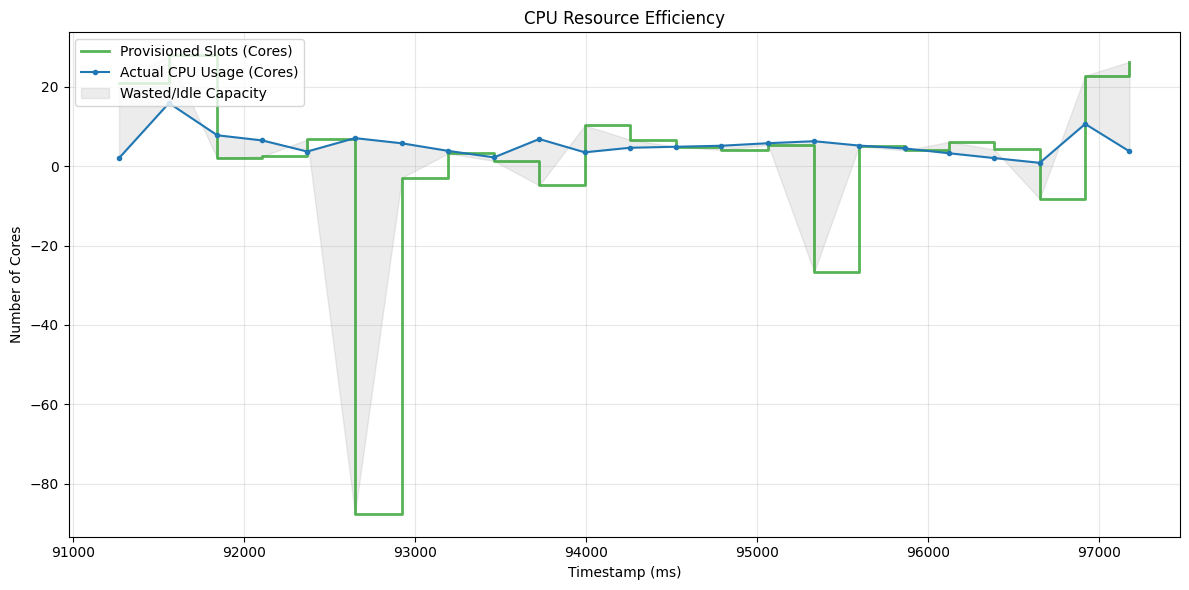

In [134]:
import matplotlib.pyplot as plt

def plot_single_scale_metrics(cpu_usage_df, cpu_provisioned_df, title_suffix=""):
    """
    Plots both metrics on the same Y-axis scale to show utilization efficiency.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # --- Provisioned Slots (The Ceiling) ---
    # We use a 'step' plot here because slot allocation changes in discrete jumps
    ax.step(cpu_provisioned_df['timestamp_ms'], 
            cpu_provisioned_df['cpu_core_provisioned'], 
            label='Provisioned Slots (Cores)', 
            color='tab:green', alpha=0.8, linewidth=2, where='post')

    # --- Actual CPU Usage (The Reality) ---
    ax.plot(cpu_usage_df['timestamp_ms'], 
            cpu_usage_df['cpu_usage'], 
            label='Actual CPU Usage (Cores)', 
            color='tab:blue', marker='o', markersize=3, linewidth=1.5)

    # --- Visualizing the Gap (Unused capacity) ---
    ax.fill_between(cpu_usage_df['timestamp_ms'], 
                    cpu_usage_df['cpu_usage'], 
                    cpu_provisioned_df['cpu_core_provisioned'], 
                    color='gray', alpha=0.15, label='Wasted/Idle Capacity')

    ax.set_xlabel('Timestamp (ms)')
    ax.set_ylabel('Number of Cores')
    ax.set_title(f'CPU Resource Efficiency{title_suffix}')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()
    return fig

# Usage
fig_single = plot_single_scale_metrics(cpu_usage_df, cpu_provisioned_df)

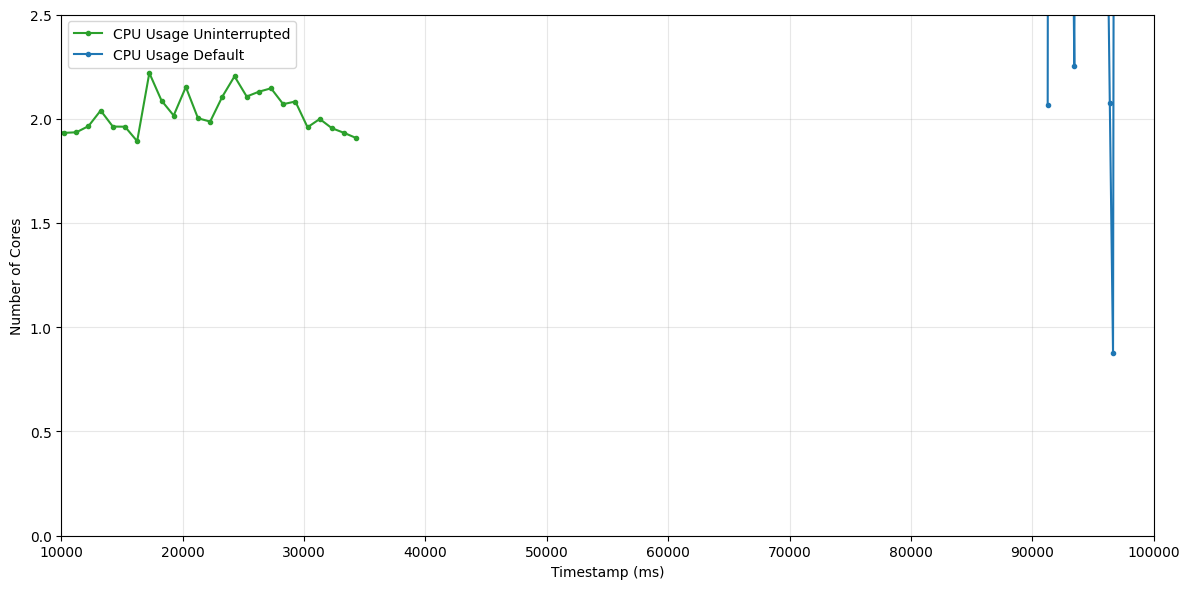

In [135]:
import matplotlib.pyplot as plt

def plot_single_scale_metrics(cpu_usage_df, cpu_provisioned_df, title_suffix=""):
    """
    Plots both metrics on the same Y-axis scale to show utilization efficiency.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(cpu_usage_df_2['timestamp_ms'], 
            cpu_usage_df_2['cpu_usage'], 
            label='CPU Usage Uninterrupted', 
            color='tab:green', marker='o', markersize=3, linewidth=1.5)
    # --- Actual CPU Usage (The Reality) ---
    ax.plot(cpu_usage_df['timestamp_ms'], 
            cpu_usage_df['cpu_usage'], 
            label='CPU Usage Default', 
            color='tab:blue', marker='o', markersize=3, linewidth=1.5)

    ax.set_xlabel('Timestamp (ms)')
    ax.set_ylabel('Number of Cores')
    ax.set_xlim(10000, 100000)
    ax.set_ylim(0, 2.5)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()
    return fig

# Usage
fig_single = plot_single_scale_metrics(cpu_usage_df, cpu_provisioned_df)